### Introduction

Traffic sign recognition is a challenging, real-world problem relevant for AI based transportation systems. Traffic signs show a wide range of variations between classes in terms of color, shape, and the presence of pictograms or text. However, there exist subsets ofcclasses (e.g., speed limit signs) that are very similar to each other. Further, the classifier
has to be robust against large variations in visual appearances due to changes in illumination, partial occlusions, rotations, weather conditions etc. Using a comprehensive traffic sign detection dataset, here we will perform classification of traffic signs, train and evaluate the different models and compare to the performance of MLPs.

![img](https://paperswithcode.com/media/datasets/GTSRB-0000000633-9ce3c5f6_Dki5Rsf.jpg)

### Dataset

The data for this mini-project is from the German Traffic Sign Detection Benchmark [GTSDB](https://benchmark.ini.rub.de/gtsdb_dataset.html). This archive contains the training set used during the IJCNN 2013 competition. In this problem, I have used the traffic detection dataset to do signal recognition.

* The main archive FullIJCNN2013.zip includes the images (1360 x 800 pixels) in PPM format, the image sections containing only the traffic signs
* Each folder from 00 to 42 contains images of different traffic signs that correspond to warnings like "speed limit 20 (prohibitory)" to "restriction ends (overtaking (trucks)) (other)"
* The images outside the numbered folder contains drivers view of the road with a traffic sign on it e.g check 00000.ppm and 11/00000.ppm contains only the traffic sign from the image.
* For our training we use only the images inside the folders and we also use only the images in gt.txt which are present inside the folder
* A file in CSV format with the ground truth, containing the following information about the images #ImgNo#.ppm;#leftCol#;##topRow#;#rightCol#;#bottomRow#;#ClassID#

Full Dataset can be downloaded [here](https://sid.erda.dk/public/archives/ff17dc924eba88d5d01a807357d6614c/FullIJCNN2013.zip) 

### Data Loading and Feature Extraction
* We define the classes that is nothing but the different traffics signs into a dictionary

In [2]:
classes_dict={
0 :'speed limit 20 (prohibitory)',
1 :'speed limit 30 (prohibitory)',
2 :'speed limit 50 (prohibitory)',
3 :'speed limit 60 (prohibitory)',
4 :'speed limit 70 (prohibitory)',
5 :'speed limit 80 (prohibitory)',
6 :'restriction ends 80 (other)',
7 :'speed limit 100 (prohibitory)',
8 :'speed limit 120 (prohibitory)',
9 :'no overtaking (prohibitory)',
10 :'no overtaking (trucks) (prohibitory)',
11 :'priority at next intersection (danger)',
12 :'priority road (other)',
13 :'give way (other)',
14 :'stop (other)',
15 :'no traffic both ways (prohibitory)',
16 :'no trucks (prohibitory)',
17 :'no entry (other)',
18 :'danger (danger)',
19 :'bend left (danger)',
20 :'bend right (danger)',
21 :'bend (danger)',
22 :'uneven road (danger)',
23 :'slippery road (danger)',
24 :'road narrows (danger)',
25 :'construction (danger)',
26 :'traffic signal (danger)',
27 :'pedestrian crossing (danger)',
28 :'school crossing (danger)',
29 :'cycles crossing (danger)',
30 :'snow (danger)',
31 :'animals (danger)',
32 :'restriction ends (other)',
33 :'go right (mandatory)',
34 :'go left (mandatory)',
35 :'go straight (mandatory)',
36 :'go right or straight (mandatory)',
37 :'go left or straight (mandatory)',
38 :'keep right (mandatory)',
39 :'keep left (mandatory)',
40 :'roundabout (mandatory)',
41 :'restriction ends (overtaking) (other)',
42 :'restriction ends (overtaking (trucks)) (other)'
}

### Import Required packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from skimage.io import imread, imshow
from sklearn import preprocessing
import os, glob
from PIL import Image
from sklearn.model_selection import GridSearchCV
# Keras
import tensorflow as tf 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Conv2D, MaxPool2D, Flatten, Dropout, MaxPooling2D
import visualkeras
import re
from sklearn.metrics import accuracy_score

#### Get the features and labels of data

* We resize the images to 30x30 (to bring them under same format)
* We prepare data (image) and labels(classes or the different traffic signs/categories)

In [5]:
data_dir = './FullIJCNN2013/'
class_images_dict = {}
data = []
labels = []

def resize_image(image_path):
    image = Image.open(image_path)
    img_resized = image.resize((30,30))
    return img_resized

for content_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, content_name)
    if os.path.isdir(class_path):
        class_id = content_name
        class_images = os.listdir(class_path) # number of images under each class
        class_images_dict[class_id] = class_images
        for image_path in class_images:
            try:
                image_full_path = os.path.join(class_path,image_path)
                img_resized = resize_image(image_full_path)
                data.append(np.array(img_resized))
                labels.append(class_id)
            except:
                 print("Error while processing "+image_path)
NUM_CATEGORIES = len(class_images_dict.keys())
print("Number of categories:%s" % NUM_CATEGORIES)
image_data = np.array(data)
image_labels = np.array(labels)

print(image_data.shape, image_labels.shape)


Number of categories:43
(1213, 30, 30, 3) (1213,)


### Data Exploration and Preprocessing
* We plot 1 image from each class (or traffic sign directory 00-42)

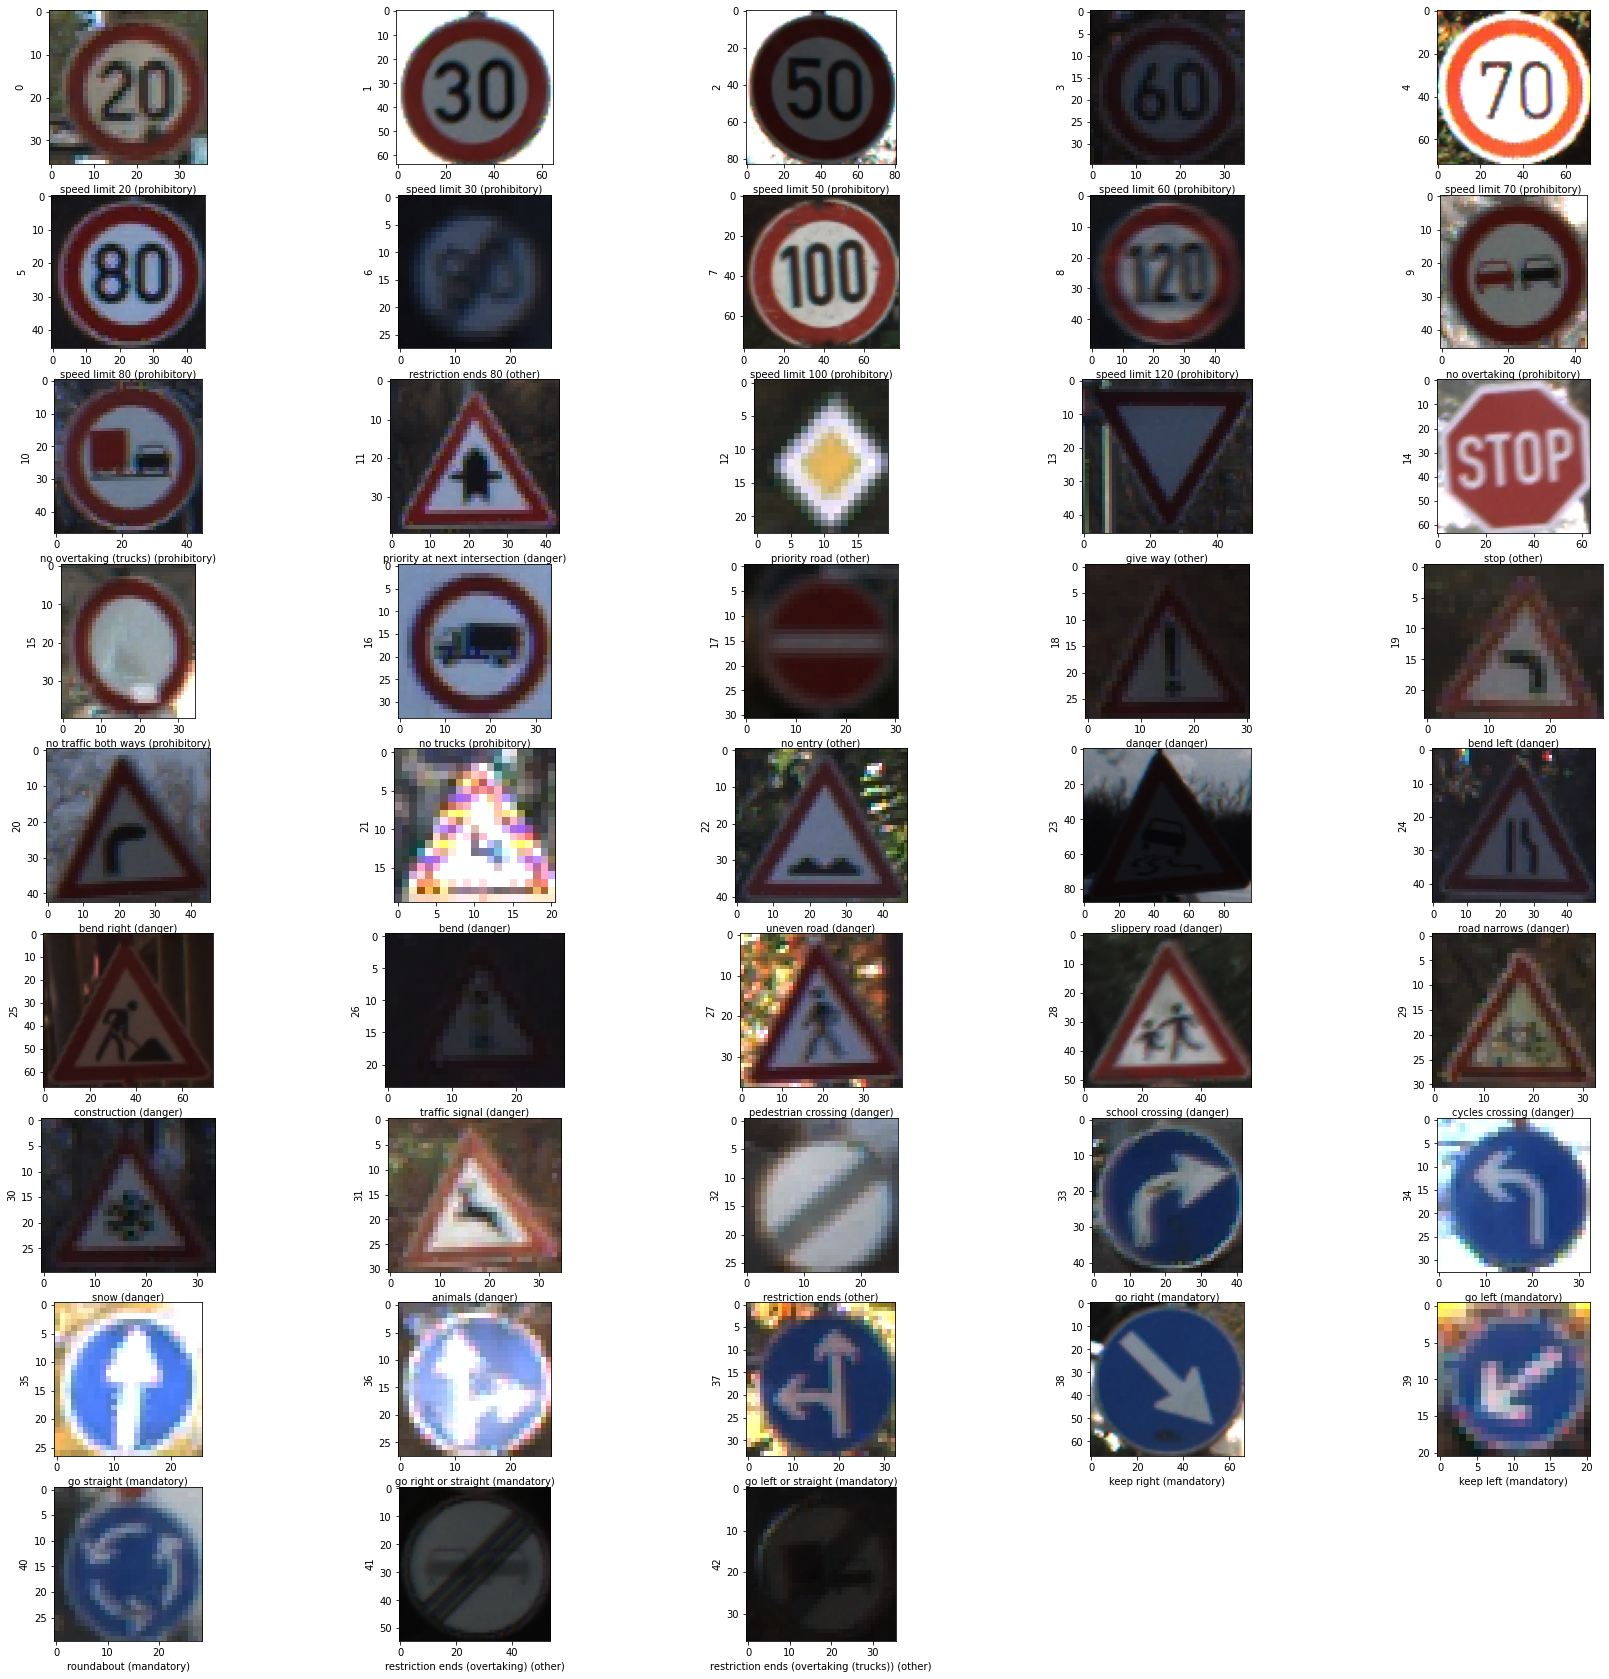

In [54]:
# test images of each class is present in ground truth
plt.figure(figsize=(30,30))
def display_image(image_path,class_id):
    plt.subplot(9,5,class_id+1)
    image = Image.open(image_path)
    #print(image)
    plt.imshow(image)
    plt.xlabel(classes_dict[class_id], fontsize = 10)#width of image
    plt.ylabel(class_id, fontsize = 10)#height of image

for key in class_images_dict.keys():
    image_path = os.path.join(data_dir,key,class_images_dict[key][0])
    display_image(image_path,int(key))


#### Plot the distribution of Classes

Text(0, 0.5, 'Number of images')

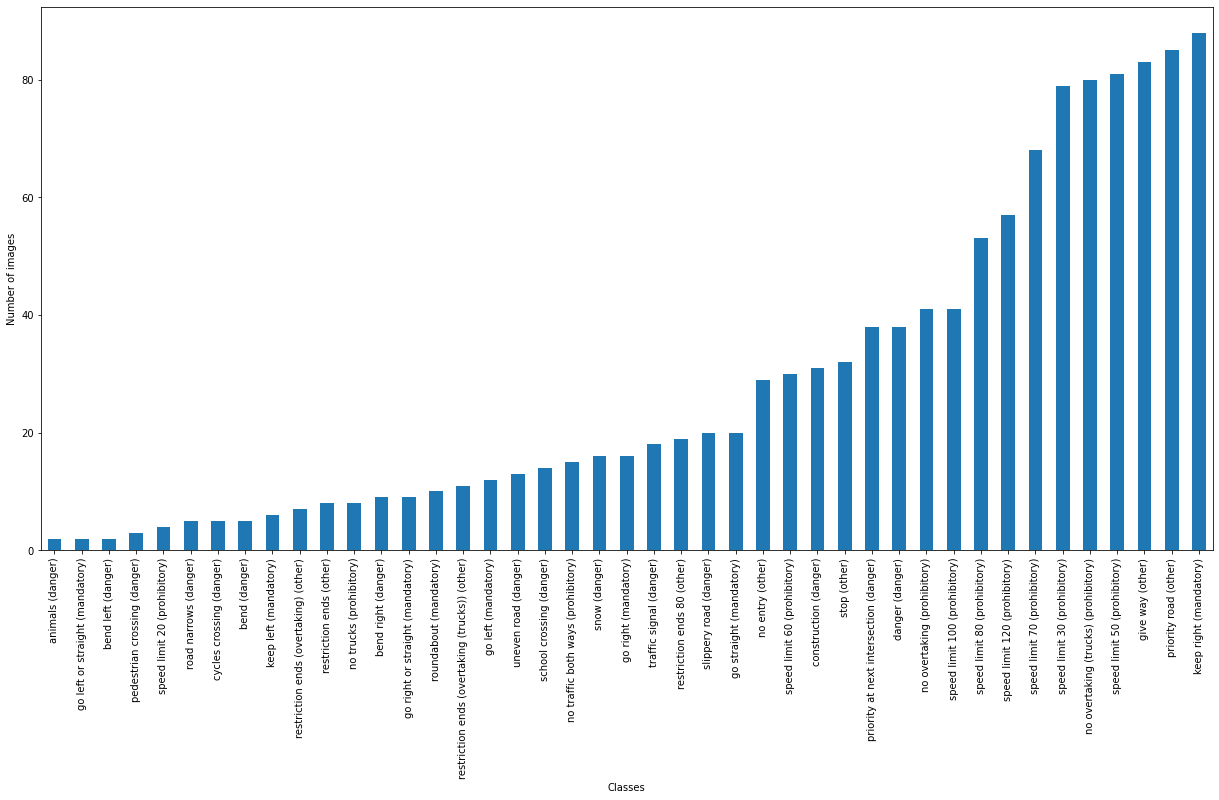

In [28]:
hist_class_images={}
for key in class_images_dict.keys():
    hist_class_images[key] = len(class_images_dict[key])
data_df= pd.Series(hist_class_images)
plt.figure(figsize = (21, 10))
data_df.sort_values().plot(kind = 'bar')
plt.xlabel('Classes')
plt.ylabel('Number of images')

#### Handy functions 
* split_data to split the data inro train and validation set
* evaluate which prints model performance metrics
* get_test_data which fetches test data from gt.txt; 
* plot_test_result we use test data from gt.txt to check if our model correctly predicts real image's (gt.txt:#ImgNo#) #ClassID#

In [3]:
def split_data(data, labels):
    shuffle_indexes = np.arange(data.shape[0])
    np.random.shuffle(shuffle_indexes)
    shuffled_data = data[shuffle_indexes]
    shuffled_labels = labels[shuffle_indexes]

    X_train, X_val, y_train, y_val = train_test_split(shuffled_data, shuffled_labels, test_size=0.3, random_state=42, shuffle=True)

    X_train = X_train/255 
    X_val = X_val/255

    print("X_train.shape", X_train.shape)
    print("X_valid.shape", X_val.shape)
    print("y_train.shape", y_train.shape)
    print("y_valid.shape", y_val.shape)

    y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
    y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

    print("After one hot encoding")
    print(y_train.shape)
    print(y_val.shape)
    return X_train, X_val, y_train, y_val

def evaluate(history, model,X_val, y_val):
    pred_conv = model.evaluate(X_val, y_val, verbose=0)
    print("%s- %.2f" % (model.metrics_names[0], pred_conv[0]))
    print("%s- %.2f" % (model.metrics_names[1], pred_conv[1]))
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

def get_test_data():
    # not all images in gt.txt is present inside the category folder, so we extract only the ones that are available
    gt_data = []
    gt_labels = []
    gt_text = np.genfromtxt(data_dir + '/gt.txt',delimiter =';', dtype= None,encoding=None)
    for line in gt_text:
        image_name = line[0]
        class_id = line[5]
        fixed_class_id = re.sub(r"^(\d$)", r'0\1', str(class_id)) #gt has folders as 0 but actual folders have leading 0 for single digit class ids
        image_path = os.path.join(data_dir,fixed_class_id,image_name)
        if os.path.exists(image_path):
            gt_labels.append(class_id)
            gt_resized_image = resize_image(image_path)
            gt_data.append(np.array(gt_resized_image))
    X_test = np.array(gt_data)
    X_test = X_test/255
    return X_test, gt_labels

def plot_test_result(pred):
    plt.figure(figsize = (10, 10))
    start_index = 0
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        prediction = pred[start_index + i]
        actual = gt_labels[start_index + i]
        col = 'g'
        if prediction != actual:
            col = 'r'
        plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
        plt.imshow(X_test[start_index + i])
    plt.show()

### CNN with Keras

In [155]:
# Build the architecture
cnn_model = Sequential()
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5), activation ='relu', input_shape = (30,30,3)))
cnn_model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = 'relu'))
cnn_model.add(MaxPool2D(pool_size = (2,2)))
cnn_model.add(Dropout(rate = 0.25))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), activation ='relu'))
cnn_model.add(MaxPool2D(pool_size = (2,2)))
cnn_model.add(Dropout(rate = 0.25))

cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation = 'relu'))
cnn_model.add(Dropout(rate = 0.5))
cnn_model.add(Dense(43, activation= 'softmax'))
# Step 2 - Compile the model
cnn_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])
# understand the model
#model.summary()
visualkeras.layered_view(cnn_model)
# Step 3 - Fit and Evaluate the model
X_train, X_val, y_train, y_val = split_data(image_data, image_labels)

cnn_history = cnn_model.fit(X_train, y_train, 
                   batch_size=200,
                   epochs=100,
                   validation_data=(X_val, y_val),verbose=0)

X_train.shape (849, 30, 30, 3)
X_valid.shape (364, 30, 30, 3)
y_train.shape (849,)
y_valid.shape (364,)
After one hot encoding
(849, 43)
(364, 43)


2022-07-24 12:38:48.318381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-24 12:38:49.005808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


loss- 0.60
accuracy- 0.94


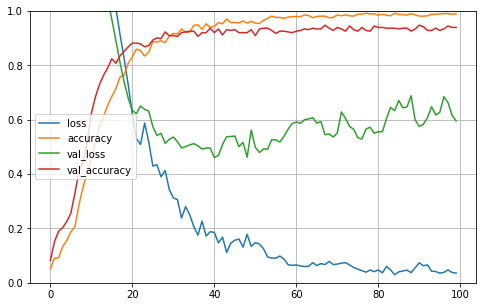

3/3 [==============================] - 0s 17ms/step


2022-07-24 12:39:11.070737: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test Data accuracy:  100.0


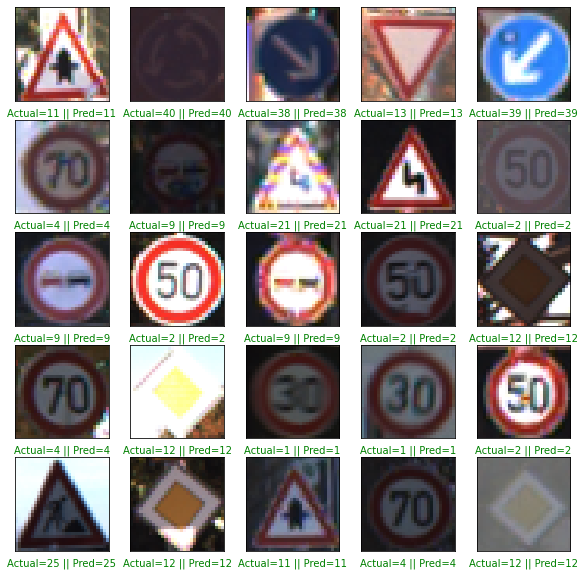

In [156]:
evaluate(cnn_history, cnn_model, X_val, y_val)
X_test, gt_labels = get_test_data()
pred = np.argmax(cnn_model.predict(X_test), axis=-1)
print('Test Data accuracy: ',accuracy_score(gt_labels, pred)*100)
plot_test_result(pred)

### MLP with Keras

In [6]:
# Step 1 - Build the architecture
keras_model = Sequential([
	keras.layers.Flatten(input_shape = (30,30,3)),
	# dense layer 1
	keras.layers.Dense(300, activation='relu'),
	# dense layer 2
	keras.layers.Dense(150, activation='relu'),
	# output layer
	keras.layers.Dense(50, activation='relu'),
	# output layer
	keras.layers.Dense(43, activation='softmax'),
])
# compile
keras_model.compile(loss = 'categorical_crossentropy', optimizer ='adam', metrics =['accuracy'])
# Step 3 - Fit and Evaluate the model
X_train, X_val, y_train, y_val = split_data(image_data, image_labels)

keras_history = keras_model.fit(X_train, y_train, 
                   batch_size=200,
                   epochs=100,
                   validation_data=(X_val, y_val),verbose=0)
				   
keras_pred = keras_model.evaluate(X_val, y_val, verbose=0)


X_train.shape (849, 30, 30, 3)
X_valid.shape (364, 30, 30, 3)
y_train.shape (849,)
y_valid.shape (364,)
After one hot encoding
(849, 43)
(364, 43)


2022-07-28 22:48:16.417180: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-07-28 22:48:16.847360: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-28 22:48:17.921921: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


loss- 0.85
accuracy- 0.83


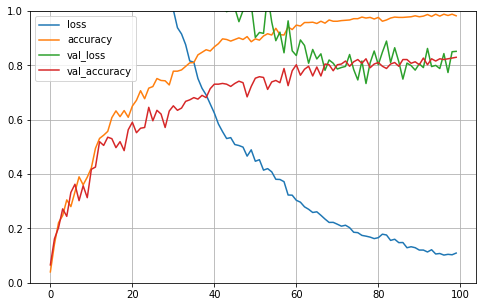

3/3 [==============================] - 0s 81ms/step


2022-07-28 22:48:39.391918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Test Data accuracy:  97.46835443037975


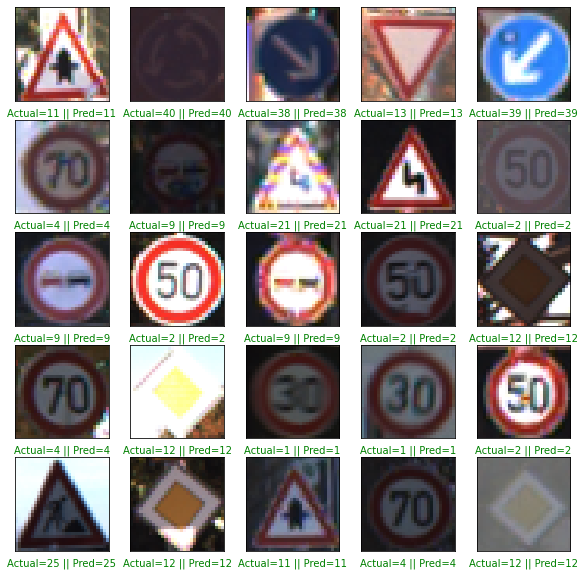

In [8]:
evaluate(keras_history, keras_model, X_val, y_val)
X_test, gt_labels = get_test_data()
keras_pred = np.argmax(keras_model.predict(X_test), axis=-1)
print('Test Data accuracy: ',accuracy_score(gt_labels, keras_pred)*100)
plot_test_result(keras_pred)

### MLP Classifer

In [171]:
X_train, X_val, y_train, y_val = split_data(image_data, image_labels)

# convert to 2d
count, height, width, rows = np.array(X_train).shape
X_train = np.reshape(np.array(X_train), (count, height*width*rows))
mlp_clf = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=300,activation='relu',solver='adam',random_state=1,batch_size=200)
mlp_model = mlp_clf.fit(X_train, y_train)

# base line
#MLPClassifier(random_state=1, max_iter=300).fit(X_train, y_train)

X_train.shape (849, 30, 30, 3)
X_valid.shape (364, 30, 30, 3)
y_train.shape (849,)
y_valid.shape (364,)
After one hot encoding
(849, 43)
(364, 43)


/Users/agitated_buddha/src/gtsdb/.env/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [172]:
count, height, width, rows = np.array(X_val).shape
X_val = np.reshape(np.array(X_val), (count, height*width*rows))
mlp_clf.predict_proba(X_val),mlp_clf.predict(X_val),mlp_clf.score(X_val, y_val)

(array([[1.77090657e-13, 1.89089428e-04, 1.06872645e-08, ...,
         5.86099895e-08, 6.43355746e-16, 7.06838078e-21],
        [2.22191001e-08, 1.02854998e-07, 1.44736659e-10, ...,
         2.09675254e-09, 1.26093580e-07, 1.28963675e-11],
        [1.81843594e-19, 2.38156063e-24, 1.78290771e-12, ...,
         3.46224813e-10, 5.24911733e-20, 7.55338252e-10],
        ...,
        [9.52650175e-30, 8.23677750e-19, 5.49499533e-23, ...,
         1.19628311e-22, 1.85462738e-16, 3.06680356e-37],
        [2.79246609e-07, 3.28650870e-09, 9.99999911e-01, ...,
         3.17922020e-07, 2.16502015e-38, 9.49512564e-20],
        [7.15424040e-23, 7.30068737e-31, 3.17840441e-21, ...,
         3.05975318e-09, 7.03035632e-12, 4.83947691e-07]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 0.6703296703296703)